In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.io import fits
import numpy as onp
import pickle

In [2]:
import jax
import jax.numpy as np
from jax import jit, value_and_grad
from jax.ops import index, index_update

In [3]:
def get_power_spectrum(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2

def get_log10_power_spectrum(image):
    return np.log10(get_power_spectrum(image))

# def get_radial(npix):
#     c = npix//2
#     xrange = np.arange(-c, c)
#     X, Y = np.meshgrid(xrange, xrange)
#     R = np.hypot(X, Y)
#     return R

# def get_outer_sum(array, r):
#     R = get_radial(array.shape[0])
#     sum_out = np.sum(array[R > r])
#     return sum_out

---

## Load and Examine data

In [4]:
import os

names = os.listdir("AMES_data/")
exclude = ["zip", "Dark", "ipy", "10nm", "03s"]

file_names = []
for i in range(len(names)):
    
    good = True
    for j in range(len(exclude)):
        if exclude[j] in names[i]:
            good = False
    if good:
        file_names.append(names[i])
        
# for name in file_names:
#     print(name)

All the data should now be homogenous

In [5]:
ox = 100
oy = -80
s = 128
cy, cx = np.array(fits.open("AMES_data/{}".format(file_names[0]))[0].data.shape)//2

files_in = []
for i in range(len(file_names)):
    image_raw = fits.open("AMES_data/{}".format(file_names[i]))[0].data
    image_onp = onp.array(image_raw[cx-s+ox:cx+s+ox, cy-s+oy:cy+s+oy]).astype(onp.float32)
    files_in.append(np.array(image_onp))
        
images = np.array(files_in)
print(images.shape)

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(95, 256, 256)


In [6]:
%%time

# Get power spectrums
power_spectrums = get_power_spectrum(images)

# Get mean power spectrum
mean_power_spectrum = np.mean(power_spectrums, axis=0)

# Get mean image
mean_image = np.mean(images, axis=0)

# Get mean image power spectrum
mean_image_power_spectrum = get_power_spectrum(mean_image)

CPU times: user 1.23 s, sys: 41.9 ms, total: 1.27 s
Wall time: 1.19 s


---

## View data

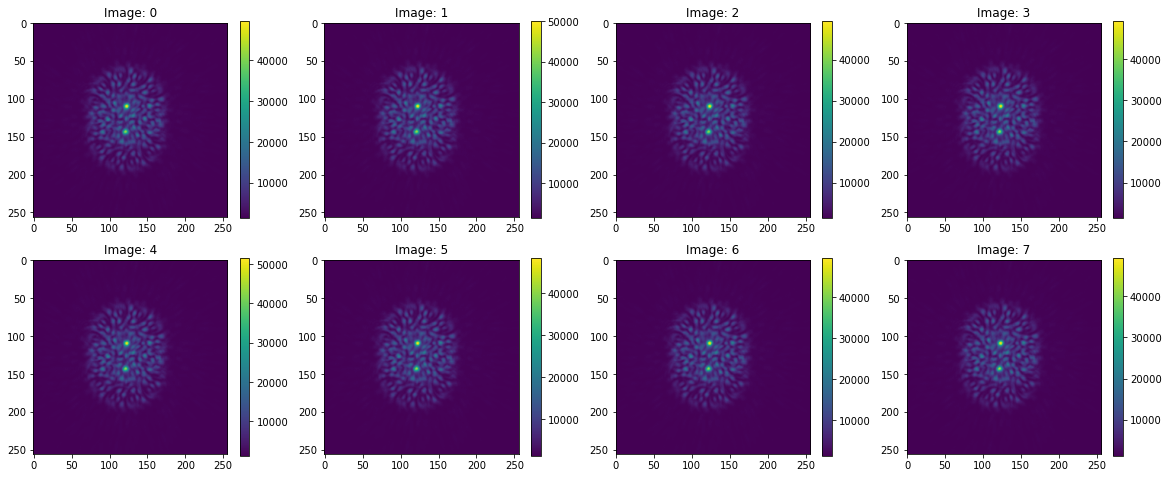

In [7]:
plt.figure(figsize=(20, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title("Image: {}".format(i))
    plt.colorbar()
plt.show()

---

## View power spectrums

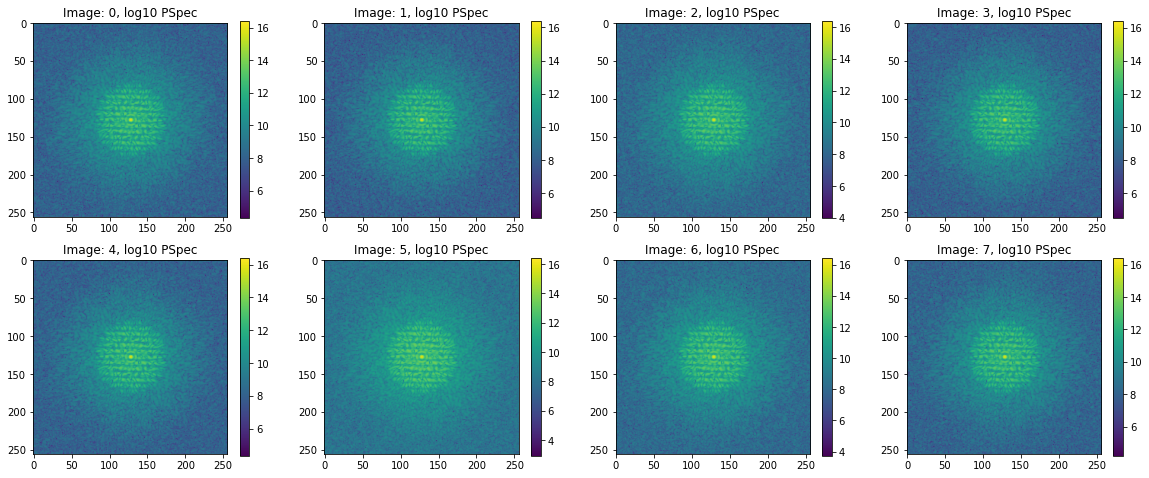

In [8]:
plt.figure(figsize=(20, 8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.log10(power_spectrums[i]))
    plt.title("Image: {}, log10 PSpec".format(i))
    plt.colorbar()
plt.show()

---

## View means, mean of power spectrums, and mean image power spectrums

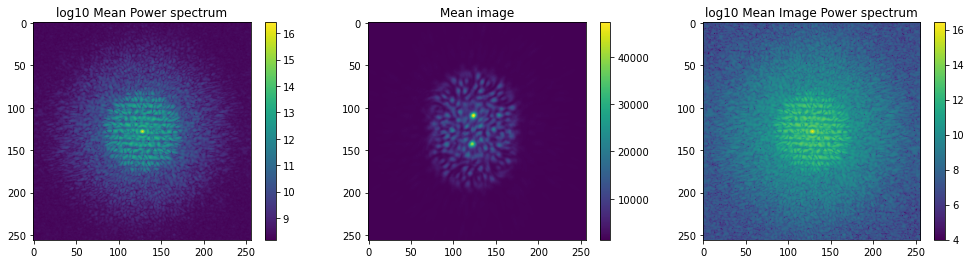

In [9]:
plt.figure(figsize=(17, 4))

plt.subplot(1, 3, 1)
plt.title("log10 Mean Power spectrum")
plt.imshow(np.log10(mean_power_spectrum))
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Mean image")
plt.imshow(mean_image)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("log10 Mean Image Power spectrum")
plt.imshow(np.log10(mean_image_power_spectrum))
plt.colorbar()

plt.show()

---

## Gradient descend on FF

### Algorithm:

We observe an image I which is constructed from each of these components:

- Image: I
- True FF: TFF
- Detector noise: BG
- PSF: PSF
- Seeing Noise: S

They combine as follows to give us our observed image:

> $ \text{I} = \text{TFF} \times (\text{PSF}*\text{S}) + \text{BG} $

where * is a convolution of the underlying PSF and the seeing.

The PSF and seeing noise S are both propaged through the optical system and hence cannot induce frequncies in the power spectrum above that determined by the diffraction limit. Since the BG noise and TFF are not subject to this same constraint all the amplitude observed in the power spectrum beyond some particular radius must nessecarily be as result of either the TFF or BG.

Over the time frames we are observing we will assume that the TFF is unchanged across all frames. The detector noise (BG) however changes in every frame, resulting in its contribution over a large number of frames averaging out to constant which should not induce power beyond the diffraction limit.

This algorithm takes advantage of this fact to learn the TFF from data with no knowledge of the underlying PSF or seeing noise by minimising the power outisde of the periphery defined by the diffraction limit. In reality there is no hard boundary as the detectors observer over a spectrum, however the cameras used only observe over ~50nm and hence this effect is ignored.

We therefore 'correct' for the TFF using the following equation

> $ \text{I}_{corrected} = \text{X} \times \text{I} = \text{X} \times [ \text{TFF} \times (\text{PSF}*\text{S}) + \text{BG} ] $

> $ \text{P} = |\mathcal{\text{F}}\{\text{I}\}|^2 $

> $ \text{Error}_1 = \sum_{\text{images}} \Big[ \sum_{\text{pixels}}^{f > f_{dlim}}(P) \Big] $

> $ \text{Error}_2 =  \sum_{\text{pixels}}^{f > f_{dlim}} \Big[ \sum_{\text{images}}(P) \Big] $ (Assumed incorrect)

This metric results in our value 'X' being the inverse of the TFF, ie Found Flat Field 

> $ FFF = \frac{1}{X} \approx TFF $


---


In [10]:
def ADAM(X, grad, LR, i, m, v, b1=0.9, b2=0.999, epsilon=1):
    m = b1 * m + (1 - b1) * grad
    v = b2 * v + (1 - b2) * np.power(grad, 2)
    m_hat = m / (1 - np.power(b1, i+1))
    v_hat = v / (1 - np.power(b2, i+1))
    X_new = X - LR * m_hat / (np.sqrt(v_hat) + epsilon)
    return X_new, m, v

def get_power_spec_min(image):
    return np.abs(np.fft.fftshift(np.fft.fft2(image)))**2
get_power_spec = jit(get_power_spec_min)


def error(X, images, r=None):
    npix = 256
    
    # Get Radial values and frequncy mask
    xrange = np.arange(-npix//2, npix//2)
    Xs, Ys = np.meshgrid(xrange, xrange)
    R = np.hypot(Xs, Ys)
    freq_mask = R > r
    
    # Apply bounds 
    X = np.maximum(X, 1) # Apply Floor
    
    # Reshape X into a square
    FF_inv = X.reshape([npix, npix])
    
    # Apply FF correction to images
    corrected_images = FF_inv * images
    
    # Get the power spectrum of all the images
    images_power_spec = get_power_spec(corrected_images)

    # Apply the frequency mask
    masked_images = freq_mask * images_power_spec
    
    # Get sum of frequncies above the diffraction limit
    power_spec_outer_sum = np.sum(masked_images)

    return power_spec_outer_sum

err_grad = value_and_grad(error, argnums=0)

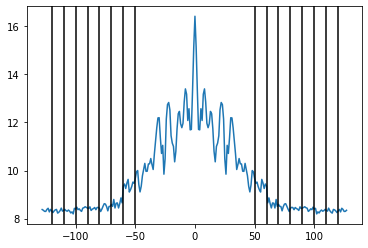

In [11]:
npix = 256
c = npix//2

diag = []
for i in range(npix):
    diag.append(np.log10(mean_power_spectrum[i, i]))

rs = np.arange(50, 130, 10)
plt.plot(np.arange(-c, c), diag)
for r in rs:
    plt.axvline(-r, c='k')
    plt.axvline(+r, c='k')

In [12]:
npix = 256

errs_out = []
Xs_out = []

for j in tqdm(range(len(rs))):
    r = rs[j]
    X = 1.1*np.ones(npix**2)
    LR = 1e-2
    m, v = 0, 0

    errs = []
    Xs = []
    epochs = [100, 200]
    for i in tqdm(range(epochs[-1]), leave=False):

        # Reduce LR 
        if i in epochs:
            LR *= 0.1

        # Get gradients and update X
        err, grads = err_grad(X, images, r=r)
        errs.append(err)
        Xs.append(X)
        X, m, v = ADAM(X, grads, LR, i, m, v)

        # Apply bounds 
        X = np.maximum(X, 1) # Apply Floor

    errs_out.append(errs)
    Xs_out.append(Xs)

errs_out = onp.array(errs_out)
errs_out = np.array(errs_out)

Xs_out = onp.array(Xs_out)
Xs_out = np.array(Xs_out)

In [12]:
# # Save
# with open("files/errs_out_AMES_test.pkl", 'wb') as f:
#     pickle.dump(errs_out, f)
    
# with open("files/Xs_out_AMES_test.pkl", 'wb') as f:
#     pickle.dump(Xs_out, f)
    
# Load
with open("files/errs_out_AMES_test.pkl", 'rb') as f:
    errs_out = pickle.load(f)
    
with open("files/Xs_out_AMES_test.pkl", 'rb') as f:
    Xs_out = pickle.load(f)

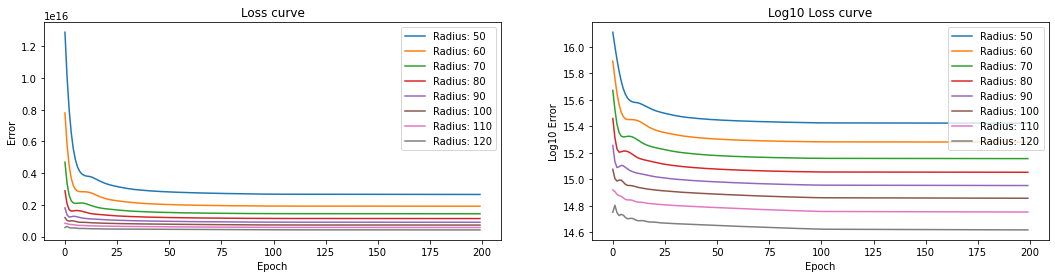

In [13]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
for i in range(len(errs_out)):
    plt.plot(errs_out[i], label="Radius: {}".format(rs[i]))
plt.legend()
plt.title("Loss curve")
plt.ylabel("Error")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
for i in range(len(errs_out)):
    plt.plot(onp.log10(errs_out[i]), label="Radius: {}".format(rs[i]))
plt.legend()
plt.title("Log10 Loss curve")
plt.ylabel("Log10 Error")
plt.xlabel("Epoch")

plt.show()

In [14]:
Xs_final = Xs_out[:, -1, :]
FFs_final = 1/Xs_final.reshape([len(rs), npix, npix])

FFs_final_zeroed = np.abs(1 - FFs_final)
FF_power_specs = get_power_spec(FFs_final)

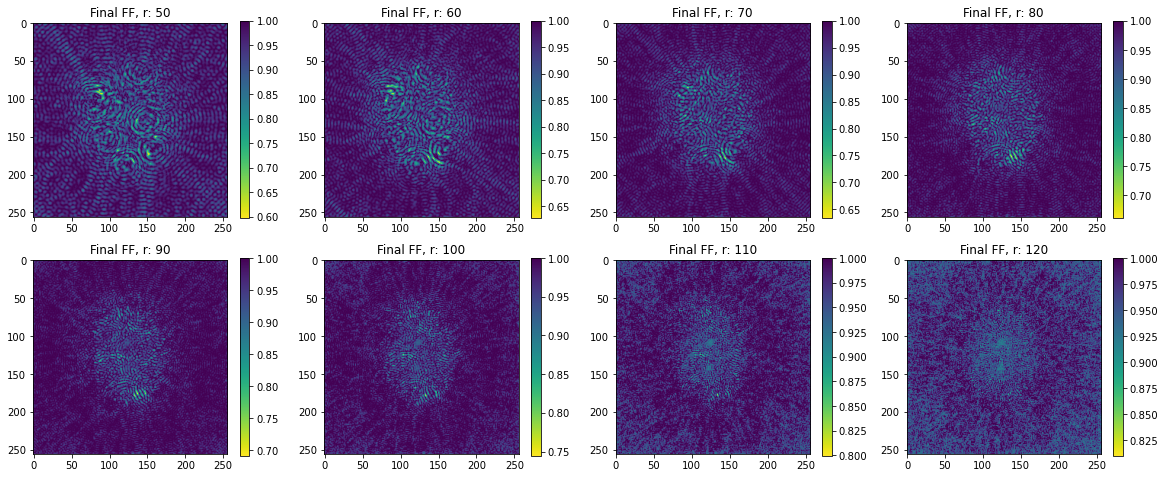

In [15]:
plt.figure(figsize=(20, 8))

for i in range(len(rs)):

    plt.subplot(2, 4, i+1)
    plt.imshow(FFs_final[i], cmap='viridis_r')
    plt.title("Final FF, r: {}".format(rs[i]))
    plt.colorbar()
    
plt.show()

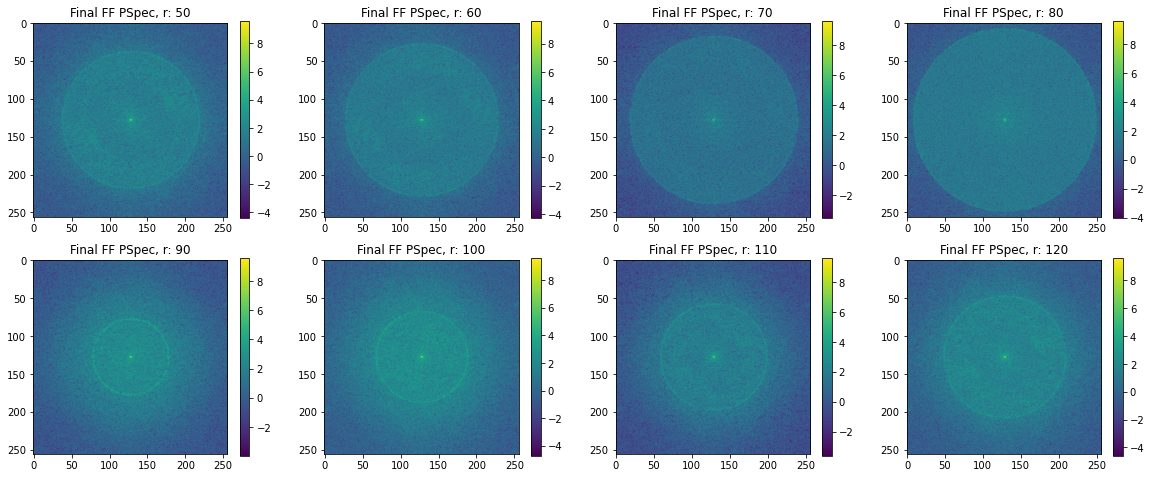

In [16]:
plt.figure(figsize=(20, 8))

for i in range(len(rs)):

    plt.subplot(2, 4, i+1)
    plt.imshow(np.log10(FF_power_specs[i]))
    plt.title("Final FF PSpec, r: {}".format(rs[i]))
    plt.colorbar()
    
plt.show()